In [ ]:
!pip install wandb

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [ ]:
config = {
        "learning_rate": 0.001,
        "epochs": 20,
        "batch_size": 32,
        "log_step": 200,
        "val_log_step": 50
        }

run = wandb.init(project="faceRecognition_tensorflowExpert", config=config)
config = wandb.config

In [ ]:
# Hyper Parameters

width = height = 224
batch_size = config.batch_size
epochs = config.epochs

In [ ]:
train_dataset_path = "/content/drive/MyDrive/7-7 dataset"

idg = ImageDataGenerator(
    rescale = 1./255,

    #Augmentation
    horizontal_flip = True,
    brightness_range = (0.7, 1.3),
    zoom_range = 0.2,
    validation_split = 0.2
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training"
)

val_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation"
)

Found 1090 images belonging to 14 classes.
Found 268 images belonging to 14 classes.


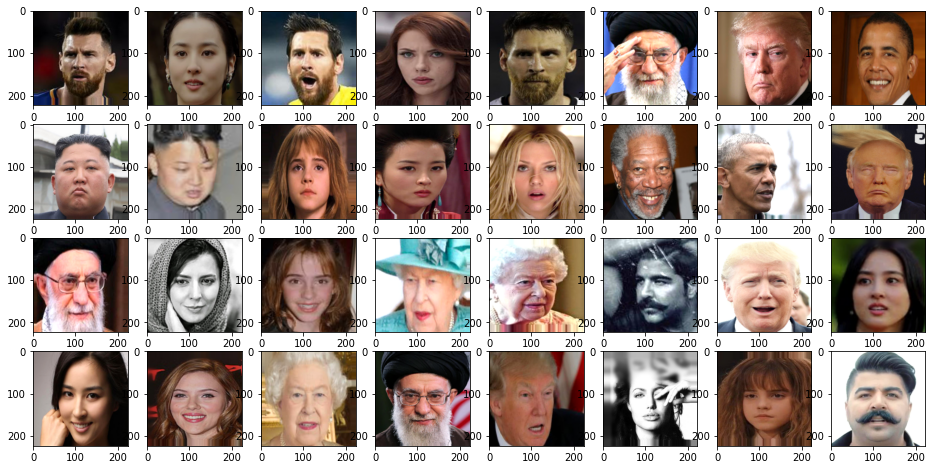

In [ ]:
X, _ = next(train_data)

plt.figure(figsize=(16, 8))
for i in range(batch_size):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i])

In [ ]:
class MyModel(Model):
    def __init__(self):
        super().__init__()
        
        self.conv2d_1 = Conv2D(32, (3, 3), activation="relu", input_shape=(width, height, 3))
        self.conv2d_2 = Conv2D(32, (3, 3), activation="relu")
        self.maxpoll_1 = MaxPooling2D()
        self.conv2d_3 = Conv2D(64, (3, 3), activation="relu")
        self.conv2d_4 = Conv2D(64, (5, 5), activation="relu")
        self.maxpoll_2 = MaxPooling2D()

        self.dropout_1 = Dropout(0.5)
        self.dropout_2 = Dropout(0.3)
        
        self.flatten = Flatten()
        self.dense_1 = Dense(512, activation="relu")
        self.dense_2 = Dense(256, activation="relu")
        self.dense_3 = Dense(14, activation="softmax")

    def call(self, x):
        y = self.conv2d_1(x)
        y = self.conv2d_2(y)
        y = self.maxpoll_1(y)
        y = self.conv2d_3(y)
        y = self.conv2d_4(y)
        y = self.maxpoll_2(y)

        y = self.flatten(y)
        y = self.dense_1(y)
        y = self.dropout_1(y)
        y = self.dense_2(y)
        y = self.dropout_2(y)
        out_final = self.dense_3(y)

        return out_final

In [ ]:
model = MyModel()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
loss_function = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
train_loss = tf.keras.metrics.MeanSquaredError()
val_loss = tf.keras.metrics.MeanSquaredError()

train_accuracy = tf.keras.metrics.CategoricalAccuracy()
val_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
# Train Loop
# .fit()

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")

    train_accuracy.reset_states()
    train_loss.reset_states()
    val_accuracy.reset_states()
    val_loss.reset_states()

    # Train
    for index, (images, labels) in enumerate(tqdm(train_data)):
        if len(train_data) <= index:
            break
        with tf.GradientTape() as gTape:
            predictions = model(images)
            loss = loss_function(labels, predictions)
            train_accuracy(labels, predictions)
            train_loss(labels, predictions)

        
        # Calculate Gradients
        gradients = gTape.gradient(loss, model.trainable_variables)

        # Update weights
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
 
    # Validation
    for index, (images, labels) in enumerate(tqdm(val_data)):
        if len(val_data) <= index:
            break
        predictions = model(images)
        loss = loss_function(labels, predictions)
        val_accuracy(labels, predictions)
        val_loss(labels, predictions)
        
    print(f"[INFO] Epoch {epoch+1}:")
    print(f"Train Accuracy: {train_accuracy.result()}")
    print(f"Train Loss (MSE): {train_loss.result()}")
    print(f"Validation Accuracy: {val_accuracy.result()}")
    print(f"Validation Loss (MSE): {val_loss.result()}")

    wandb.log({'epochs': epoch+1,
                'loss': train_loss.result(),
                'acc': float(train_accuracy.result()), 
                'val_loss': val_loss.result(),
                'val_acc':float(val_accuracy.result())})
    
run.finish()

Epoch: 1


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


[INFO] Epoch 1:
Train Accuracy: 0.15596330165863037
Train Loss (MSE): 0.06621547788381577
Validation Accuracy: 0.3283582031726837
Validation Loss (MSE): 0.05671517178416252
Epoch: 2


100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


[INFO] Epoch 2:
Train Accuracy: 0.39449542760849
Train Loss (MSE): 0.0529489628970623
Validation Accuracy: 0.48507463932037354
Validation Loss (MSE): 0.048210229724645615
Epoch: 3


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


[INFO] Epoch 3:
Train Accuracy: 0.5669724941253662
Train Loss (MSE): 0.041044533252716064
Validation Accuracy: 0.5858209133148193
Validation Loss (MSE): 0.03962317854166031
Epoch: 4


100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


[INFO] Epoch 4:
Train Accuracy: 0.7018348574638367
Train Loss (MSE): 0.03010752983391285
Validation Accuracy: 0.6305969953536987
Validation Loss (MSE): 0.037469323724508286
Epoch: 5


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


[INFO] Epoch 5:
Train Accuracy: 0.7412844300270081
Train Loss (MSE): 0.02610255964100361
Validation Accuracy: 0.7052238583564758
Validation Loss (MSE): 0.028860323131084442
Epoch: 6


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


[INFO] Epoch 6:
Train Accuracy: 0.7944954037666321
Train Loss (MSE): 0.02128133736550808
Validation Accuracy: 0.7164179086685181
Validation Loss (MSE): 0.02766980044543743
Epoch: 7


100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


[INFO] Epoch 7:
Train Accuracy: 0.8330275416374207
Train Loss (MSE): 0.017252283170819283
Validation Accuracy: 0.746268630027771
Validation Loss (MSE): 0.02656463533639908
Epoch: 8


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


[INFO] Epoch 8:
Train Accuracy: 0.8678898811340332
Train Loss (MSE): 0.014060934074223042
Validation Accuracy: 0.7164179086685181
Validation Loss (MSE): 0.02812446653842926
Epoch: 9


100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


[INFO] Epoch 9:
Train Accuracy: 0.8834862112998962
Train Loss (MSE): 0.01239620428532362
Validation Accuracy: 0.7611940503120422
Validation Loss (MSE): 0.026627859100699425
Epoch: 10


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


[INFO] Epoch 10:
Train Accuracy: 0.8963302969932556
Train Loss (MSE): 0.010694541968405247
Validation Accuracy: 0.7126865386962891
Validation Loss (MSE): 0.029550055041909218
Epoch: 11


100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


[INFO] Epoch 11:
Train Accuracy: 0.8972477316856384
Train Loss (MSE): 0.010188429616391659
Validation Accuracy: 0.753731369972229
Validation Loss (MSE): 0.027555549517273903
Epoch: 12


100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


[INFO] Epoch 12:
Train Accuracy: 0.9403669834136963
Train Loss (MSE): 0.0063909124583005905
Validation Accuracy: 0.8022388219833374
Validation Loss (MSE): 0.019648227840662003
Epoch: 13


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


[INFO] Epoch 13:
Train Accuracy: 0.9220183491706848
Train Loss (MSE): 0.008735071867704391
Validation Accuracy: 0.7873134613037109
Validation Loss (MSE): 0.02192530408501625
Epoch: 14


100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


[INFO] Epoch 14:
Train Accuracy: 0.9394495487213135
Train Loss (MSE): 0.006687047891318798
Validation Accuracy: 0.8208954930305481
Validation Loss (MSE): 0.0208832249045372
Epoch: 15


100%|██████████| 9/9 [00:09<00:00,  1.04s/it]


[INFO] Epoch 15:
Train Accuracy: 0.9385321140289307
Train Loss (MSE): 0.006149096414446831
Validation Accuracy: 0.8171641826629639
Validation Loss (MSE): 0.01866072043776512
Epoch: 16


100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


[INFO] Epoch 16:
Train Accuracy: 0.9403669834136963
Train Loss (MSE): 0.005841060075908899
Validation Accuracy: 0.8805969953536987
Validation Loss (MSE): 0.01382116787135601
Epoch: 17


100%|██████████| 9/9 [00:10<00:00,  1.11s/it]


[INFO] Epoch 17:
Train Accuracy: 0.9422018527984619
Train Loss (MSE): 0.005977654829621315
Validation Accuracy: 0.8246268630027771
Validation Loss (MSE): 0.020279088988900185
Epoch: 18


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


[INFO] Epoch 18:
Train Accuracy: 0.9458715319633484
Train Loss (MSE): 0.005903726909309626
Validation Accuracy: 0.7425373196601868
Validation Loss (MSE): 0.0253861416131258
Epoch: 19


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


[INFO] Epoch 19:
Train Accuracy: 0.9587156176567078
Train Loss (MSE): 0.004414509516209364
Validation Accuracy: 0.7873134613037109
Validation Loss (MSE): 0.022049685940146446
Epoch: 20


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


[INFO] Epoch 20:
Train Accuracy: 0.9642201662063599
Train Loss (MSE): 0.0039726183749735355
Validation Accuracy: 0.8097015023231506
Validation Loss (MSE): 0.020286280661821365



acc,▁▃▅▆▆▇▇▇▇▇▇█████████
epochs,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▅▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_acc,▁▃▄▅▆▆▆▆▆▆▆▇▇▇▇█▇▆▇▇
val_loss,█▇▅▅▃▃▃▃▃▄▃▂▂▂▂▁▂▃▂▂
acc,0.96422
epochs,20
loss,0.00397
val_acc,0.8097
val_loss,0.02029


In [ ]:
model.save_weights("/content/drive/MyDrive/faceRecognition_tensorflowExpert/model/faceRecognition.h5")